In [2]:
%matplotlib inline
#%matplotlib widget

In [3]:
#############imports######################################################################
import cv2 as cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import trackpy as tp
from ipywidgets import HBox, Textarea, interact
import scipy as sc
from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import interp1d


In [4]:
def timeToSec(timeStr):#Transform m:s format into total number of seconds
    timeArr = timeStr.split(':')
    timeMin = float(timeArr[0])
    timeSec = float(timeArr[1])
    totSec = timeMin*60+timeSec
    return totSec
def thetafit(theta,A,B):
    return A*np.sin(theta+B)
def expShift(t,A,C):
    return np.exp(A*(t))*C
def linearfit(x,A,B):
    return A*x+B

In [10]:
expSumFileName ='C:\\Users\\User\\Documents\\Eden\\locate_git_code\\kappa_meas_made_bots\\kappa_exp.csv'
expSum = pd.read_csv(expSumFileName,index_col=0)
fps=25
#indexes=np.r_[3:63, 73:202].tolist()
#indexes=np.r_[182].tolist()
#expSum=expSum.iloc[range(0,13)]
expSum=expSum[(expSum.starting_point=='up')&(expSum.bottype=='fronter')]
print(expSum)

           date operator  bottype  No..1  angle  angle_err  stars  bots  \
No.                                                                       
1    20240617.0     Eden  fronter      5    5.4        0.1    NaN   NaN   
2           NaN      NaN  fronter      5    5.4        0.1    NaN   NaN   
3           NaN      NaN  fronter      5    5.4        0.1    NaN   NaN   
4           NaN      NaN  fronter      5    5.4        0.1    NaN   NaN   
5           NaN      NaN  fronter      5    5.4        0.1    NaN   NaN   
..          ...      ...      ...    ...    ...        ...    ...   ...   
133         NaN      NaN  fronter      5   11.5        0.4    NaN   NaN   
134         NaN      NaN  fronter      5   11.5        0.4    NaN   NaN   
135         NaN      NaN  fronter      5   11.5        0.4    NaN   NaN   
136         NaN      NaN  fronter      5   11.5        0.4    NaN   NaN   
137         NaN      NaN  fronter      5   11.5        0.4    NaN   NaN   

                        

In [11]:
data = {'filename':[],'slope':[],'bottype':[],'A':[],'index':[]}
columns = ['filename','slope','bottype','A','index']
data_table = pd.DataFrame(data=data,columns=columns)
count=0
for index,row in (expSum.iterrows()):
    print(index)
    path_bot=row.BotLocatingFile#expSum.LocatingFile
    path_battery=row.BatteryLocatingFile
    startMin =row.start_min#row.start_min
    endMin =row.end_min#row.end_min
    start_point=timeToSec(startMin)*25#6000
    end_point=(timeToSec(endMin))*25#8000#frameCount
    df_bot=pd.read_csv(path_bot,index_col=0)
    #df=df[((df.frame<end_point)&(df.frame>=start_point))]
    df_battery=pd.read_csv(path_battery,index_col=0)
    evec_x_array=[]
    evec_y_array=[]
    frames=[]
    for frame in np.arange(start_point,end_point):
        try:
            relevant_data_bot=df_bot[(df_bot.frame==frame)]
            relevant_data_battery=df_battery[(df_battery.frame==frame)]
            evec_x=(relevant_data_bot.x.iloc[0] - relevant_data_battery.x.iloc[0])
            evec_y=-(relevant_data_bot.y.iloc[0] - relevant_data_battery.y.iloc[0])
            evec_x_array.append(evec_x)
            evec_y_array.append(evec_y)
            frames.append(frame)
        except:
            continue
    evec_x_array=np.array(evec_x_array)
    evec_y_array=np.array(evec_y_array)
    theta=np.arctan2(evec_y_array,evec_x_array)
    cond=theta<0
    cond=cond.astype(int)
    cond=cond*2*np.pi
    theta=theta+cond
    results=pd.DataFrame({'frame':frames,'theta':theta})
    y_plot=np.tan(theta/2)
    valid=(y_plot<1e10)#1/np.tan(2*results.theta)#+1/np.sin(results.theta)
    #plt.plot(results.theta,theta_V)
    t=results.frame/25
    p0=np.array([0.2,1])
    sucsses=False
    count=0
#popt,pcov = sc.optimize.curve_fit(expShift,t[valid],y_plot[valid],p0=p0,maxfev=5000)

    while sucsses==False:
        try:
            popt,pcov = sc.optimize.curve_fit(expShift,t[valid],y_plot[valid],p0=p0,maxfev=5000)
            sucsses=True
        except:
            print("trying again")
            p0=np.random.randint(2,size=(0,10))
            count=count+1
            if count==10:
                break
    print(popt)
    y=np.exp(popt[0]*t)*popt[1]
    line_data={'filename':[row.path],'slope':[row.angle],'bottype':[row.bottype],'A':[popt[0]],'index':[index]}
    data_line= pd.DataFrame(data=line_data,columns=columns)
    data_table = pd.concat([data_table,data_line],ignore_index=True)
print(data_table)

1
[  -1.04675945 -959.88332083]
2
[-1.90400460e+00 -1.21054869e+09]
3
[-1.49396032e+00 -8.26237855e+10]
4
[-8.73364887e-01 -7.24432310e+07]
5
[-1.21242395e+00 -2.36050894e+14]
6
[-8.19875970e-01 -1.00274813e+12]
7
[-1.01089675e+00 -8.87592373e+16]
8
[-6.61344887e-01 -2.48296957e+13]
9
[-2.75038718e-01 -9.16884623e+06]
10
[-8.39398957e-01 -3.07100339e+26]
11
[-1.23749428e+00 -1.88785239e+45]
12
[-3.67687697e-01 -1.19100288e+15]
13
[-8.11637745e-01 -3.81289971e+37]
28
[ -0.63995885 -12.00789887]
29
[-1.71564314e+00 -1.02003275e+13]
30
[-1.52751663e+00 -6.25258095e+22]
31
[-7.12660464e-01 -2.34957735e+15]
32
[-5.00166974e-01 -7.43252524e+14]
33
[-9.74494171e-01 -1.42829952e+34]
34
trying again
trying again
trying again
trying again
trying again
trying again
trying again
trying again
trying again
trying again
[-9.74494171e-01 -1.42829952e+34]
35
[-8.84038922e-01 -6.16184308e+41]
36
trying again
trying again
trying again
trying again
trying again
trying again
trying again
trying again
tryin

In [12]:
print(data_table.A.mean())

-0.8014902548584373


In [13]:
print(data_table.A.std()/len(data_table.A)**0.5)

0.04404442833106777


In [14]:
print(data_table.groupby(['slope','bottype']).mean())

                      A       index
slope bottype                      
2.25  fronter -0.551860   57.714286
4.35  fronter -0.522408  115.307692
5.40  fronter -0.965684    7.000000
7.25  fronter -0.820913   88.857143
9.40  fronter -0.937749   33.000000
11.50 fronter -1.031320  130.500000


C:\Users\User\AppData\Local\Temp\ipykernel_22988\3027379440.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(data_table.groupby(['slope','bottype']).mean())


[-0.11687555 -0.45090586]
[0.0410348  0.13690003]


C:\Users\User\AppData\Local\Temp\ipykernel_22988\2768436418.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mean=data_table.groupby(['slope']).mean()
C:\Users\User\AppData\Local\Temp\ipykernel_22988\2768436418.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_std=data_table.groupby(['slope']).std()


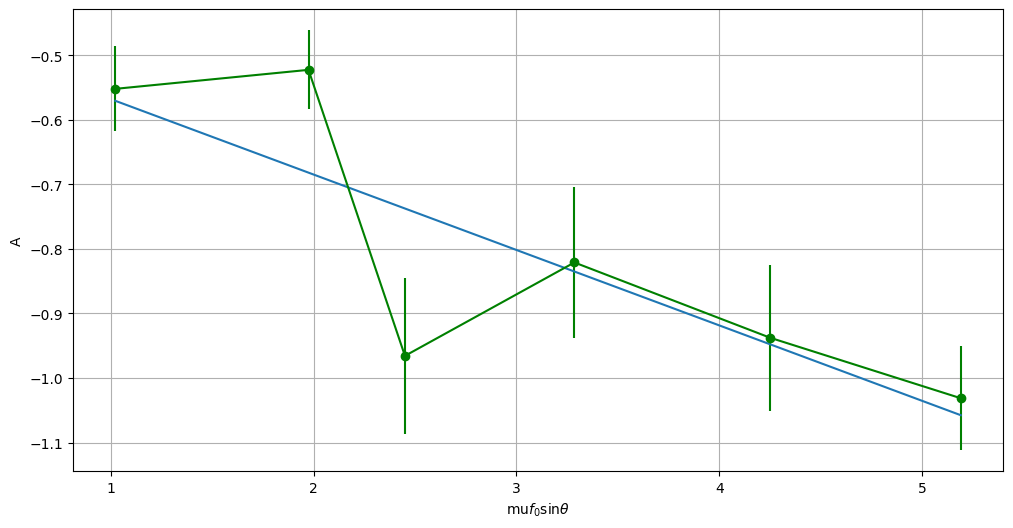

In [15]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
zero_deg=8.325#deg
v0=3.77#cm/sec
mu_f_0=v0/np.sin(np.deg2rad(zero_deg))
data_mean=data_table.groupby(['slope']).mean()
data_std=data_table.groupby(['slope']).std()
data_count=data_table.groupby(['slope']).count()
data_error=data_std/np.sqrt(data_count)
mu_f=mu_f_0*np.sin(np.deg2rad(data_mean['A'].index))
ax.errorbar(mu_f,data_mean['A'],yerr=data_error['A']
            ,linestyle='-',marker='o',color='g',label='fronter')
p0=np.array([0.2,1])
popt,pcov = sc.optimize.curve_fit(linearfit,mu_f,data_mean['A'],p0=p0,maxfev=5000)
print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)
y=popt[0]*mu_f+popt[1]
ax.plot(mu_f,y)
ax.set_xlabel(r'mu$f_0$sin$\theta$')
ax.set_ylabel('A')
ax.grid()